# **Analysis of DNA Sequence Motifs**

In [1]:
import numpy.typing as npt
from typing import Any, Callable, List

This exercise walks you through the application of a convolutional neural network (CNN) to DNA sequence data.

We will use PyTorch as a neural network framework.
While there is no shortage of content and tutorials on how to get started with PyTorch in general, in most cases images or language samples are taken as input data.
For using DNA sequences as an input, there are many great projects out there that have developed PyTorch frameworks to model all sorts of biological phenomena.
Examples include [Selene](https://github.com/FunctionLab/selene), [Basset](https://github.com/davek44/Basset), and [DNABERT](https://github.com/jerryji1993/DNABERT) as well as [DNABERT-2](https://github.com/Zhihan1996/DNABERT_2).
However, thewe frameworks can be quite sophisticated and difficult to dive into.

Hence, here we provide a more appropriate starting point for all future DNA modelers.

# Generation of synthetic DNA data

Usually scientists might be interested in predicting something like a binding score, an expression strength, or identifying transcription factor binding events.
But here, we are going to keep it simple: our goal is to observe if a deep learning model can learn to detect a very small, simple pattern in a DNA sequence and score it appropriately.

So arbitrarily, let's say that given an 8-mer DNA sequence, give it points for each base as follows:

- A = +20 points
- C = +17 points
- G = +14 points
- T = +11 points

Then, for every 8-mer, sum up its total points and then take the average.
For example, `AAAA` would score $\frac{20+20+20+20}{4}=20$.
`ACAA` would score $\frac{20+17+20+20}{4}=19.25$.

> Keep in mind that hese values are arbitrary; we are only building our own simple system for demonstration purposes.

Let's add one more thing to our scoring system.
To simulate something like [motifs](https://en.wikipedia.org/wiki/Sequence_motif) influencing gene expression, a given sequence gets a +10 bump if `TAT` appears anywhere in the 8-mer, and a -10 bump if it has a `GCG` in it.

> A sequence motif is a nucleotide or amino-acid sequence pattern that is widespread and usually assumed to be related to biological function of the macromolecule.
> DNA sequence motifs are often represented as a [sequence logo](https://en.wikipedia.org/wiki/Sequence_logo).

##### ❓ **Q1** &mdash; Scoring system

Complete the following function to score a DNA sequence according to the scheme defined above.

In [2]:
import numpy as np


def motif_score(sequence: str) -> float:
    base_scores = {"A": 20, "C": 17, "G": 14, "T": 11}

    # Single-base scoring
    score = np.mean([base_scores[base] for base in sequence])

    # Motif scoring
    if "TAT" in sequence:
        score += 10
    if "GCG" in sequence:
        score -= 10

    return score

In [3]:
sequence = "AAAA"
print(f"motif_score({sequence}) = {motif_score(sequence=sequence)}")
sequence = "ACAA"
print(f"motif_score({sequence}) = {motif_score(sequence=sequence)}")

motif_score(AAAA) = 20.0
motif_score(ACAA) = 19.25


##### ❓ **Q2** &mdash; Data generation

Recall that _k_-mers are substrings of length $k$ contained within a biological sequence.
Also, a sequence of length $L$ has $L - k + 1$ _k_-mers and $n^k$ total possible _k_-mers, where $n$ is the number of possible monomers.

The following function generates a list of all possible _k_-mers for a given _k_.

In [4]:
from itertools import product


def generate_all_kmers(k: int) -> List[str]:
    return ["".join(x) for x in product(["A", "C", "G", "T"], repeat=k)]

Generate all possible $4^8 = 65,536$ 8-mers (i.e., $n = 4$, $k = 8$).
Then, compute the motif score for each 8-mer.
Finally, store the results in a [`pandas.DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) with the columns `sequence` and `motif_score`.

In [5]:
import pandas as pd

eightmers = generate_all_kmers(k=8)
data = []
for sequence in eightmers:
    data.append([sequence, motif_score(sequence=sequence)])
df = pd.DataFrame(data, columns=["sequence", "motif_score"])
df.head()

,sequence,motif_score
0,AAAAAAAA,20.000
1,AAAAAAAC,19.625
2,AAAAAAAG,19.250
3,AAAAAAAT,18.875
4,AAAAAACA,19.625


# Data preprocessing

## Training set & validation set

##### ❓ **Q3** &mdash; Data split

First things first: split the data randomly into a training set (80%) and a validation set (20%).

> Feel free to use the [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

In [6]:
import os
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, train_size=0.8, random_state=42)

print(f"Training set{os.linesep}------------")
print(f"Dataframe shape: {train_df.shape}")
print(f"Dataframe head:{os.linesep}{train_df.head()}")
print("")
print(f"Validation set{os.linesep}--------------")
print(f"Dataframe shape: {val_df.shape}")
print(f"Dataframe head:{os.linesep}{val_df.head()}")

Training set
------------
Dataframe shape: (52428, 2)
Dataframe head:
       sequence  motif_score
108    AAAACGTA       17.750
2440   AAGCGAGA        7.375
35243  GAGCGGGT        4.750
53679  TCACGGTT       14.375
25971  CGCCCTAT       25.500

Validation set
--------------
Dataframe shape: (13108, 2)
Dataframe head:
       sequence  motif_score
63127  TTCGGCCT       14.000
41103  GGAAGATT       15.500
3989   AATTGCCC       15.875
37213  GCACCCTC       16.250
30665  CTCTTAGC       14.750


## One-hot encoding

Recall that for neural networks to make predictions, in general you have to give it your input as a matrix of numbers.
While for example images are by definition already matrices of numbers, we have to put in some extra work for our DNA sequences.

We will use one-hot encoding for our DNA sequences.
The following function performs the one-hot encoding.

In [7]:
def one_hot_encode(sequence: str) -> npt.NDArray[Any]:
    code = {
        "A": [1.0, 0.0, 0.0, 0.0],
        "C": [0.0, 1.0, 0.0, 0.0],
        "G": [0.0, 0.0, 1.0, 0.0],
        "T": [0.0, 0.0, 0.0, 1.0],
        "N": [0.0, 0.0, 0.0, 0.0],
    }
    return np.array([code[base] for base in sequence])

In [8]:
sequence = "GATTACA"
print(f"one_hot_encode({sequence}) =")
print(f"{one_hot_encode(sequence=sequence)}")

one_hot_encode(GATTACA) =
[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


## Building a PyTorch dataset

In PyTorch, a dataset is represented by a regular Python class that inherits from the [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class.
You can think of it as a kind of a Python _list of tuples_, each tuple corresponding to one data point (features, label).

The most fundamental methods it needs to implement are:

- `__init__()`: it takes whatever arguments needed to build a list of tuples. This may be a CSV file that will be loaded and processed; it may be two tensors, one for features, another one for labels; or anything else, depending on the task at hand. However, there is no need to load the entire dataset here in the constructor. Indeed, if your dataset is big it is recommended to load data on demand, i.e., whenever `__get_item__()` is called.
- `__get_item__()`: it allows the dataset to be indexed, so that it can work like a list (`dataset[i]`). It must return a tuple (features, label) corresponding to the requested data point. We can either return the corresponding slices of our pre-loaded dataset or, as mentioned above, load them on demand.
- `__len__()`: it should simply return the size of the entire dataset.

Then, with a PyTorch dataset available, we have the opportunity of using PyTorch's [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class for loading our data.

##### ❓ **Q4** &mdash; Building a custom PyTorch dataset

Let's build our own simple custom dataset that takes our dataframe (with the columns `sequence` and `motif_score`) as input. Complete the following code.

In [9]:
from torch.utils.data import Dataset
import torch


class MotifScoreDataset(Dataset):
    def __init__(self, df: pd.DataFrame) -> None:
        # Features
        sequences = list(df["sequence"].values)
        self.ohe_sequences = torch.stack(
            tensors=[torch.tensor(data=one_hot_encode(sequence=s)) for s in sequences]
        )  # this will be a (n_items x sequence_len x ohe_len) tensor

        # Labels
        motif_scores = list(df["motif_score"].values)
        self.motif_scores = torch.tensor(data=motif_scores).unsqueeze(
            dim=1
        )  # this will be a (n_items x 1) tensor

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        features = self.ohe_sequences[index]
        label = self.motif_scores[index]
        return features, label

    def __len__(self) -> int:
        return self.ohe_sequences.shape[0]

In [10]:
# Create the training and validation dataset from our dataframes
train_dataset = MotifScoreDataset(df=train_df)
val_dataset = MotifScoreDataset(df=val_df)

In [11]:
# Inspect the first item from the training dataframe
train_df_head = train_df.head(n=1)
train_df_ohe_sequence = one_hot_encode(sequence=train_df_head.iloc[0]["sequence"])
train_df_motif_score = train_df_head.iloc[0]["motif_score"]
print(f"OHE sequence from dataframe:{os.linesep}{train_df_ohe_sequence}{os.linesep}")
print(f"Motif score from dataframe: {train_df_motif_score}{os.linesep}")

# Inspect the first item from the training dataset
datapoint_features, datapoint_label = train_dataset[0]
print(f"OHE sequence from dataset:{os.linesep}{datapoint_features}{os.linesep}")
print(f"Motif score from dataset: {datapoint_label}")

OHE sequence from dataframe:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]

Motif score from dataframe: 17.75

OHE sequence from dataset:
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.]], dtype=torch.float64)

Motif score from dataset: tensor([17.7500], dtype=torch.float64)


In [12]:
from torch.utils.data import DataLoader

batch_size = 128

train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size)

# Definition of a CNN model in PyTorch

Here we will use a CNN that consists of four layers:

1. [Conv1d](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html): a 1D convolution over our sequences
2. [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html): the rectified linear unit (ReLU) activation function
3. [Flatten](https://pytorch.org/docs/stable/generated/torch.flatten.html): to flatten the data into a one-dimensional tensor
4. [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html): a final linear transformation to infer an estimate for the motif score

We will use PyTorch's [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) class to build a network in which the layers are automatically connected.

Before implementing the CNN, we need to take a more detailed look into the convolutional layer:

- We will input our one-hot encoded sequences (8-mers) into the convolutional layer.
- Hence, the convolutional layer will have 4 input channels, where each channel corresponds to a specific position of a one-hot encoding. (Recall that our one-hot encodings have the length 4, because we encode the 4 bases A, C, G, and T. E.g., A is encoded as `[1 0 0 0]`.)
- We will use 32 filters, i.e., kernels, in our convolutional layer.
- Each filter/kernel will have a size $K$ of 3.
- Hence, for each 4-channel input sequence of length $L$, the convolutional layer will produce a 32-channel output sequence of length $L - K + 1$.

##### ❓ **Q5** &mdash; Definition of a CNN model

Complete the following code for a CNN model with the parameters as described above.

In [13]:
import torch.nn as nn


class MotifScoreCNN(nn.Module):
    def __init__(self, sequence_len: int) -> None:
        super().__init__()

        n_input_channels = 4  # i.e., length of our OHE scheme
        n_filters = 32  # i.e., no. of kernels
        kernel_size = 3
        conv_out_len = sequence_len - kernel_size + 1

        self.net = nn.Sequential(
            nn.Conv1d(
                in_channels=n_input_channels,
                out_channels=n_filters,
                kernel_size=kernel_size,
            ),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(in_features=n_filters * conv_out_len, out_features=1),
        )

    def forward(self, x: torch.Tensor) -> torch.float:
        # Our data loader provides batches with dimensions
        # (n_items x sequence_len x ohe_len). We hence have to switch the
        # second and third dimension before passing the data to our network.
        x = x.permute(0, 2, 1)
        return self.net(x)

# Training & evaluation

##### ❓ **Q6** &mdash; Training and validation functions

In the training process, we expose our CNN model multiple times (`n_epochs` times, to be precise) to the entire dataset.
In each epoch, the `train_step()` and `val_step()` functions will be called.
In each of these functions we iterate in batches through our training and validation sets.

Complete the following code for the training and validation steps.

In [14]:
import torch.utils.data


def make_train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.modules.loss._Loss,
    optimizer: torch.optim.Optimizer,
    device: str,
) -> Callable:
    def train_step() -> float:
        model.train()
        losses = []

        for x_batch, y_batch in dataloader:
            # Send the batches to the device where the model "lives"
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # Forward pass & loss
            y_batch_hat = model(x_batch.float())
            loss = loss_fn(y_batch_hat, y_batch.float())
            losses.append(loss.item())

            # Gradients & parameter update
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        return np.mean(losses)

    return train_step


def make_val_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.modules.loss._Loss,
    device: str,
) -> Callable:
    def val_step() -> float:
        model.eval()
        losses = []

        # Even though it won't make a difference in our simple model, it is
        # good practice to wrap the validation inner loop with this context
        # manager to disable any gradient calculation that you may
        # inadvertently trigger. Gradients belong in training, not in
        # validation.
        with torch.no_grad():
            for x_batch, y_batch in dataloader:
                # Send the batches to the device where the model "lives"
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                # Forward pass & loss
                y_batch_hat = model(x_batch.float())
                loss = loss_fn(y_batch_hat, y_batch.float())
                losses.append(loss.item())

        return np.mean(losses)

    return val_step

##### ❓ **Q7** &mdash; Running the model

Finally, everything is set up to run our model.

Complete the following code.
Pay attention to track the training and validation losses.

In [15]:
device = "cpu"
if torch.cuda.is_available():
    print("CUDA is available on your system.")
    device = "gpu"
else:
    print("CUDA is not available on your system.")

lr = 0.01
sequence_len = len(train_df["sequence"].values[0])
model = MotifScoreCNN(sequence_len=sequence_len).to(device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()
n_epochs = 25

train_step = make_train_step(
    model=model,
    dataloader=train_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
)

val_step = make_val_step(
    model=model, dataloader=val_dataloader, loss_fn=loss_fn, device=device
)

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    train_loss = train_step()
    train_losses.append(train_loss)

    val_loss = val_step()
    val_losses.append(val_loss)

    print(
        f"Epoch [{(epoch + 1):2}/{n_epochs:2}] | train loss: {train_loss:.4f} | validation loss: {val_loss:.4f}"
    )

CUDA is not available on your system.
Epoch [ 1/25] | train loss: 13.8454 | validation loss: 9.5588
Epoch [ 2/25] | train loss: 7.3535 | validation loss: 5.8043
Epoch [ 3/25] | train loss: 5.4205 | validation loss: 4.1919
Epoch [ 4/25] | train loss: 4.1618 | validation loss: 2.7489
Epoch [ 5/25] | train loss: 3.0029 | validation loss: 4.6335
Epoch [ 6/25] | train loss: 2.1489 | validation loss: 1.6196
Epoch [ 7/25] | train loss: 1.6877 | validation loss: 2.4046
Epoch [ 8/25] | train loss: 1.5152 | validation loss: 1.9299
Epoch [ 9/25] | train loss: 1.3291 | validation loss: 1.9376
Epoch [10/25] | train loss: 1.2367 | validation loss: 1.0235
Epoch [11/25] | train loss: 1.1417 | validation loss: 0.9751
Epoch [12/25] | train loss: 1.1682 | validation loss: 1.0120
Epoch [13/25] | train loss: 1.0523 | validation loss: 0.9632
Epoch [14/25] | train loss: 1.0302 | validation loss: 0.9728
Epoch [15/25] | train loss: 1.0661 | validation loss: 0.9588
Epoch [16/25] | train loss: 1.0043 | validatio

##### ❓ **Q8** &mdash; Visualization of training and validation losses

Finally, we can inspect the training and validation losses visually.
Plot the training and validation losses in a single figure.

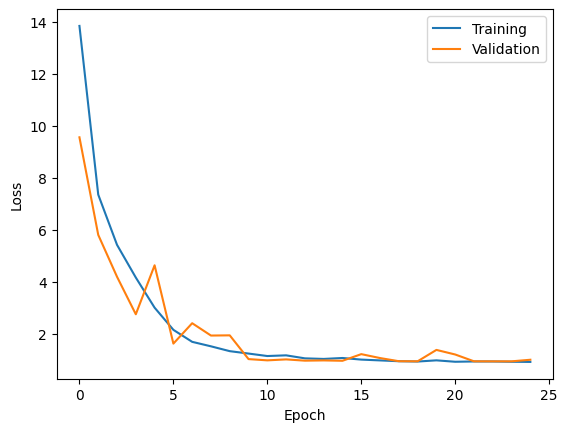

In [16]:
import matplotlib.pyplot as plt

plt.plot(train_losses, color="tab:blue", label="Training")
plt.plot(val_losses, color="tab:orange", label="Validation")
plt.xlabel(xlabel="Epoch")
plt.ylabel(ylabel="Loss")
plt.legend()
plt.show()